To install Stan on your system, see this [link](https://mc-stan.org/users/interfaces/)

You can run Stan from R, Python, command-line, MATLAB, Julia, Stata, Mathematica, Scala. 

In [2]:
library(rstan)                              #install package
options(mc.cores = parallel::detectCores()) #tell Stan to use multiple cores
library(viridis)                            #package for nice colors

Simulate some data from a hierarchical graphical regression model

Parameters for the simulation:

In [5]:
P  <- 12                              #number of groups
p  <- 10                              #number of individuals within group
n  <- sample(30:100,p*P,replace=TRUE) #data points per location
pi <- c(0,cumsum(n))                  #vector index for dataset stacked as single column
Pi <- pi[seq(1,length(pi),p)]         #extract every pth index to separate groups
N  <- sum(n)                          #total number of data points
y  <- numeric(N)                      #space for y vector
x  <- numeric(N)                      #space for x vector

beta1_u    <- 0.2  #universal slope
beta0_u    <- 1.0  #universal intercept
beta1_g_sd <- 2.5  #standard deviation of group node slopes
beta0_g_sd <- 2.0  #standard deviation of group node intercepts

##--Sample group level parameters, conditional on universals--############
beta1_g    <- rnorm(P,mean=beta1_u,sd=beta1_g_sd) 
beta0_g    <- rnorm(P,mean=beta0_u,sd=beta0_g_sd)

beta1_i_sd <- 0.5  #standard deviation of individual slopes within groups
beta0_i_sd <- 0.2  #standard deviation of individual intercepts within groups

##--Sample individual parameters, conditional on group--################
beta1_i    <- rnorm(p*P,mean=rep(beta1_g,each=p),sd=beta1_i_sd)
beta0_i    <- rnorm(p*P,mean=rep(beta0_g,each=p),sd=beta0_i_sd)

sigma_y    <- 0.25 #standard deviation for the measurement error
sigma_x    <- 0.2  #standard deviation for independent variable

Loop over groups and individuals, simulate data, and append to two growing vectors `x` and `y`

In [6]:
k <- 1 #counter for p*P

for(i in 1:P){                           #loop over groups
	for(j in 1:p){                       #loop over individuals
		xtmp <- rnorm(n[k],sd=sigma_x)   #generate random 'x' data
		y[(pi[k]+1):pi[k+1]] <- beta0_i[k] + beta1_i[k]*xtmp + rnorm(n[k],sd=sigma_y)  #move through each pi[k]+1 to pi[k+1] segment and concatenate data 
		x[(pi[k]+1):pi[k+1]] <- xtmp                                                   
		k <- k + 1
	}
}

Make a plot

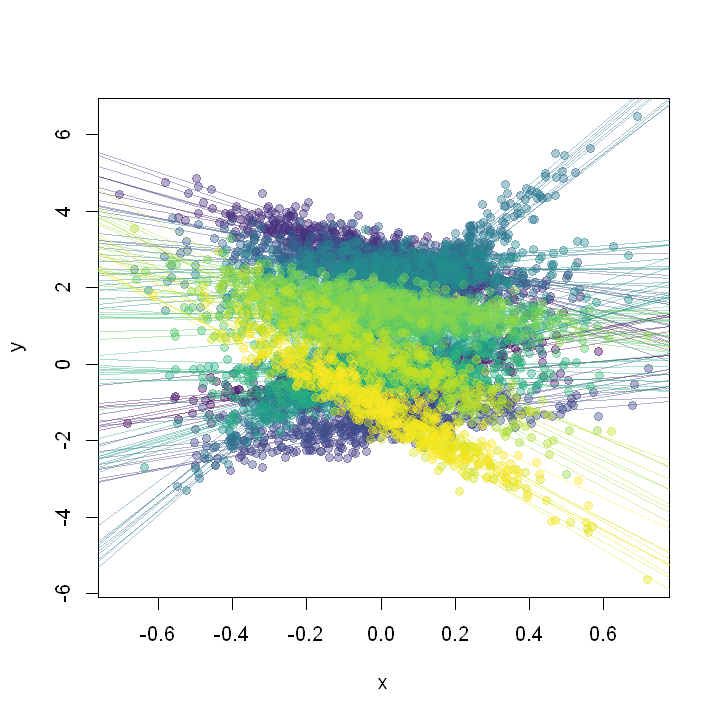

In [18]:
options(repr.plot.width=6, repr.plot.height=6)

cols <- viridis(p*P)

par(mfrow=c(1,1)) 
k <- 1
plot(-999,xlim=range(x),ylim=range(y),ylab='y',xlab='x')  #open empty plot
for(i in 1:P){
	for(j in 1:p){
		points(x[(pi[k]+1):pi[k+1]], y[(pi[k]+1):pi[k+1]],col=adjustcolor(cols[k],alpha.f=0.4),pch=19)
		abline(lm(y[(pi[k]+1):pi[k+1]] ~ x[(pi[k]+1):pi[k+1]]),col=adjustcolor(cols[k],alpha.f=0.4))
	    k <- k + 1	
	}
}


Compile the Stan code

In [8]:
mod <- stan_model('hierarchical_regression.stan')  #pre-compile

Package the data for Stan

In [9]:
data <- list(P=P,p=p,N=N,pi=pi,n=n,y=y,x=x)

Run MCMC

In [19]:
mcmc <- sampling(mod, data=data, iter=2000, warmup=1000, open_progress=TRUE)

Extract the samples

In [11]:
post <- extract(mcmc)

Take a look at some names and dimensions in the list

In [ ]:
names(post)
dim(post$beta1_u)
dim(post$beta1_g)
dim(post$beta0_i)

Make some plots of the fitted distributions

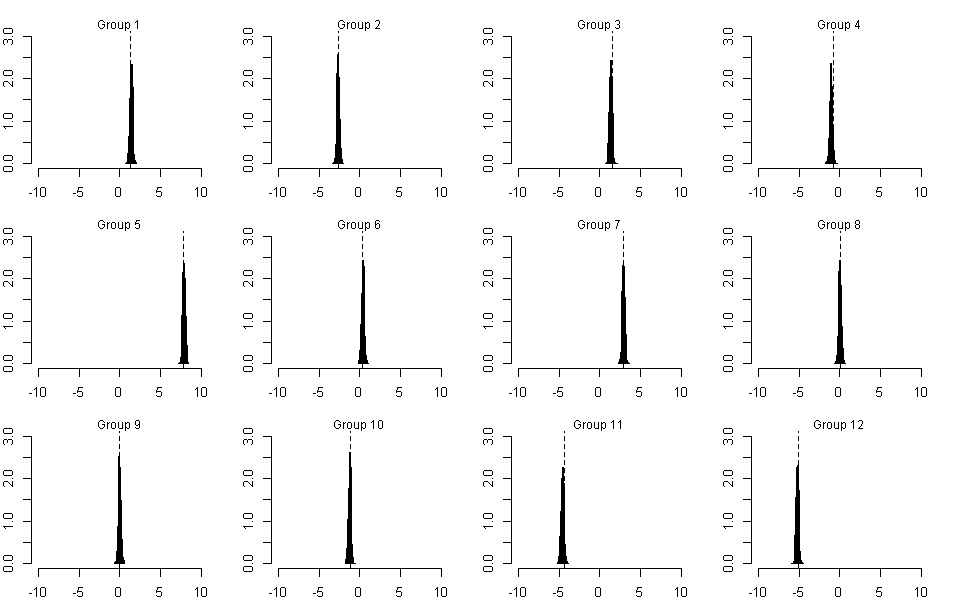

In [21]:
options(repr.plot.width=8, repr.plot.height=5)
par(mfrow=c(3,4),mar=c(2,2,2,2))
for(i in 1:(P)){
    hist(post$beta1_g[,i],main='',xlim=c(-10,10),freq=FALSE,ylim=c(0,3)); mtext(paste('Group',i),cex=0.6);
    abline(v=beta1_g[i],lwd=1,lty=2)
}

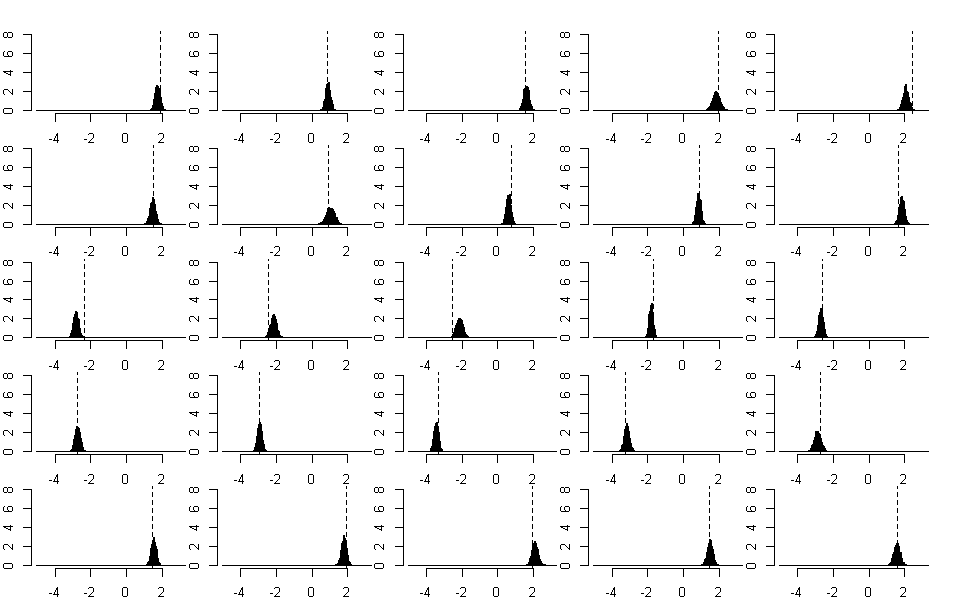

In [22]:
options(repr.plot.width=8, repr.plot.height=5)
par(mfrow=c(5,5),mar=c(1,1,1,1),oma=c(1,1,1,1))
for(i in 1:25){
    hist(post$beta1_i[,i],main='',breaks=seq(-5,5,length.out=300),xlim=c(-5,3),freq=FALSE,ylim=c(0,8))
    abline(v=beta1_i[i],lwd=0.1,lty=2)
}